### QUESTION 1: Factors that impact salary

To predict salary you will be building either a classification or regression model, using features like the location, title, and summary of the job. If framing this as a regression problem, you will be estimating the listed salary amounts. You may instead choose to frame this as a classification problem, in which case you will create labels from these salaries (high vs. low salary, for example) according to thresholds (such as median salary).

You have learned a variety of new skills and models that may be useful for this problem:
- NLP
- Unsupervised learning and dimensionality reduction techniques (PCA, clustering)
- Ensemble methods and decision tree models
- SVM models

Whatever you decide to use, the most important thing is to justify your choices and interpret your results. *Communication of your process is key.* Note that most listings **DO NOT** come with salary information. You'll need to able to extrapolate or predict the expected salaries for these listings.

In [1]:
from bs4 import BeautifulSoup
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

import pickle
import re

In [2]:
from collections import Counter, defaultdict
from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, \
mean_squared_error, roc_curve, auc
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.pipeline import Pipeline
from nltk.tokenize import sent_tokenize, word_tokenize
import nltk

In [3]:
import warnings
warnings.filterwarnings('ignore')

### NLP and more cleaning specific to Q1

In [4]:
df = pd.read_pickle("./allcleaned.pkl")

In [5]:
df.shape

(2945, 17)

In [6]:
# the first thing we need to do is get rid of rows without salaries for Q1
df[df.avgsalary==0].avgsalary.count()

2113

In [7]:
df.drop(df[df.avgsalary==0].index, axis=0, inplace=True)

In [8]:
df.dropna(axis=0, subset=['avgsalary'], inplace=True)

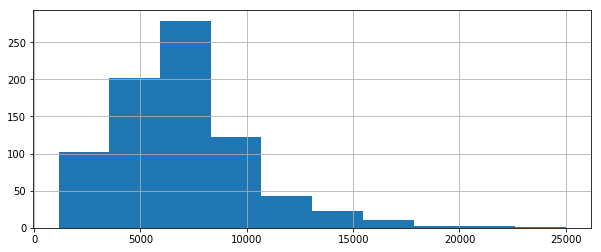

In [9]:
df.avgsalary.hist(figsize=(10,4), bins=10)

In [10]:
# there is a significant right skew in the salary. however, since this problem will be tackled
# as a classification problem using the quartile system as a divider, this should not pose a problem

In [11]:
df.avgsalary.describe()

count      787.000000
mean      6892.115488
std       3193.367428
min       1150.000000
25%       4750.000000
50%       6500.000000
75%       8500.000000
max      25000.000000
Name: avgsalary, dtype: float64

run vectorizer on jd first.

In [12]:
# it's one giant string. cool.
df.jd[51]

'Roles & ResponsibilitiesPalo IT is an innovation & agile development company. From Design Research to DevOps, we are in the business of end-to-end development of breakthrough digital experiences. As a community of innovators and developers, we also aim at renewing the way organizations operate, promoting sustainable business agility, user-centricity and open collaboration while having fun doing it.  Started in Paris in 2009 and with offices in Singapore, Hong Kong and Mexico, we are looking for our next superstar to join our exciting team in Singapore.  At Palo IT, our employees are not widgets. They are in the center of all our projects and successes. We offer an exciting and creative working environment, with endless opportunities to develop your skills, travel and take your career to the next level. Get in touch to find out more!  Your profile & role on the project  YOU:  \uf0a7 Thrive on challenge. When was the last time you fail?  \uf0a7 Are curious & always learning. What are yo

In [13]:
def cleanrd1(text):
    text = text.lower()
    # removes carriage returns
    text = re.sub('/(\r\n)+|\r+|\n+|\t+/i', ' ', text)
    # remove everything NOT in the brackets (with caret)
    text = re.sub(r"[^a-zA-Z ]"," ",text)
    return text

clean1 = lambda x: cleanrd1(x)


In [14]:
df['text'] = df.jd.apply(clean1)

In [15]:
# save to pickle first
df.to_pickle('./Q1textcleaned.pkl')

In [16]:
df.text[51]

'roles   responsibilitiespalo it is an innovation   agile development company  from design research to devops  we are in the business of end to end development of breakthrough digital experiences  as a community of innovators and developers  we also aim at renewing the way organizations operate  promoting sustainable business agility  user centricity and open collaboration while having fun doing it   started in paris in      and with offices in singapore  hong kong and mexico  we are looking for our next superstar to join our exciting team in singapore   at palo it  our employees are not widgets  they are in the center of all our projects and successes  we offer an exciting and creative working environment  with endless opportunities to develop your skills  travel and take your career to the next level  get in touch to find out more   your profile   role on the project  you     thrive on challenge  when was the last time you fail     are curious   always learning  what are you up to ri

In [17]:
corpus = [t for t in df.text]

In [18]:
from nltk.corpus import stopwords
# import stopwords with option of adding more customized ones later 
stop = stopwords.words('english')

In [19]:
# get stem words 
# tried porter stemmer but results were not encouraging so dropped. 

# from nltk.stem import PorterStemmer
# wordlist=[]
# newcorpus = []
# porter=PorterStemmer()

# for c in corpus[:2]:
#     wordblock = word_tokenize(c)
#     for word in wordblock:
#         wordlist.append(porter.stem(word))
#         print(wordlist) 
#     newcorpus.append(' '.join(wordlist))

In [20]:
cvec = CountVectorizer(stop_words=stop, ngram_range=(1, 2), max_df=0.9, max_features=20000)

In [21]:
# builds vocab using fit and transforms words into numbers w transform
cvec.fit(corpus)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.9, max_features=20000, min_df=1,
        ngram_range=(1, 2), preprocessor=None,
        stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs',... 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"],
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [22]:
X = cvec.transform(corpus)

In [23]:
Xt = pd.DataFrame(X.todense(), 
                    columns=cvec.get_feature_names(), index = df.index)

In [24]:
Xt.shape

(787, 20000)

In [25]:
#top words
Xt.sum().sort_values(ascending=False).head(20)

data            3561
business        2110
team            1363
work            1330
skills          1243
management      1176
requirements    1044
knowledge        986
development      926
solutions        832
learning         824
strong           789
support          783
working          781
design           768
project          765
ability          710
technical        700
years            684
analytics        658
dtype: int64

In [26]:
df.columns

Index(['advertiser', 'avgsalary', 'district', 'elapsed', 'industry', 'jd',
       'jobtitle', 'jobtype', 'portal', 'searchstring', 'seniority', 'source',
       'employees', 'firmsize', 'function', 'rank', 'level', 'text'],
      dtype='object')

In [27]:
#df.rank pulls up function, so rename to avoid clash
df.rename(columns={'rank': 'ranked'}, inplace=True)

In [28]:
df.elapsed = pd.to_numeric(df.elapsed)

In [29]:
# check for nulls
df.isnull().sum()

advertiser        0
avgsalary         0
district        184
elapsed           0
industry         41
jd                0
jobtitle          0
jobtype          29
portal            0
searchstring      0
seniority        41
source            0
employees         1
firmsize          0
function         41
ranked           41
level            41
text              0
dtype: int64

In [30]:
# impute median rank to null ranked rows as this is numerical and will cause problems in modelling
# later if not handled
np.median(~df.ranked.isnull())

1.0

In [31]:
df.ranked.fillna(np.median(~df.ranked.isnull()), inplace=True)

In [32]:
# for others, replace with 'None' as these are categoricals
todrop = ['district','industry', 'jobtype']
for t in todrop:
    df[t].fillna('None',  inplace=True)

In [33]:
# create final dataframe for classification exercise 

In [34]:
X = df.select_dtypes(include='number')
X.head()

,avgsalary,elapsed,employees,firmsize,function,ranked,level
0,9000.0,0.0,20000.0,3,0.0,3.0,3.0
1,5100.0,0.0,1.0,0,2.0,2.0,0.0
2,17500.0,0.0,1.0,0,3.0,3.0,0.0
3,10500.0,0.0,1.0,0,4.0,8.0,4.0
4,8500.0,0.0,1.0,0,2.0,7.0,5.0


In [35]:
X = X.drop(['avgsalary', 'function','level','employees'], axis=1)
X.shape

(787, 3)

In [36]:
# some jobs belong to multiple industries, so let's split the industry variable
dummy = df.industry.str.strip().str.get_dummies(sep=',')

In [37]:
dummy.shape

(787, 63)

In [38]:
X = pd.concat([X, dummy], axis=1)
X.shape

(787, 66)

In [39]:
# columns to convert into dummy variables 
dummies = ['district', 'jobtype', 'portal', 'searchstring']

In [40]:
dummy = pd.get_dummies(df[dummies], prefix=dummies, drop_first=True)
X = pd.concat([X, dummy], axis=1)
X.shape

(787, 104)

In [41]:
# check for NAs
X.columns[X.isnull().any()]

Index([], dtype='object')

In [42]:
# prefix jd word columns with 'jd' for ID purposes
Xt.columns = 'jd_' + Xt.columns
Xt.shape

(787, 20000)

In [43]:
X = pd.concat([X, Xt], axis=1)

In [44]:
X.shape

(787, 20104)

In [45]:
# let y fall into 2 salary buckets, corresp to below and above the median
df['salbucket'] = np.where(df.avgsalary>=df.avgsalary.quantile(.5), 1, 0)

In [46]:
y = df.salbucket

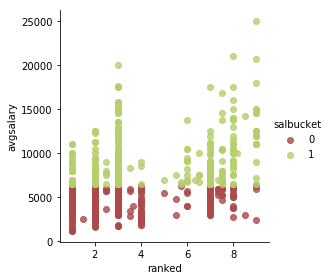

In [47]:
sns.lmplot(x = 'ranked', y = 'avgsalary', data = df, hue = 'salbucket', \
           height = 4, fit_reg = False, palette = 'tab20b_r')
plt.show()

In [48]:
df.to_pickle('./Q1premodel.pkl')

### MODELLING

In [146]:
# what is our baseline y?
# we chose 50-50
# therefore baseline = 0.5
baseline = 0.5

In [147]:
# split dataset into train and test set
ss= StandardScaler()
X_train, X_test, y_train, y_test = \
           train_test_split(X, y, \
                            random_state = 140, test_size = 0.2, stratify=y)
# scale data fit and transform train set but just transform test set
Xs_train = ss.fit_transform(X_train)
Xs_test = ss.transform(X_test)

Xs_train = pd.DataFrame(Xs_train, columns=X_train.columns)
Xs_test = pd.DataFrame(Xs_test, columns=X_test.columns)

<div class="alert alert-warning">
    1. Logistic Regression + GridSearchCV

In [51]:
# Applying Logistic Regression using GridSearchCV to find optimum parameters and perform
# cross-validation at the same time.

logr_parameters = {
    'penalty':['l1','l2'],
    'solver':['liblinear'],
    'C':np.logspace(0,4,20) #np.linspace(1, 25, 25)
}

In [52]:
logr_gridsearcher = GridSearchCV(LogisticRegression(), logr_parameters, cv=5, verbose=1)
logr_result = logr_gridsearcher.fit(Xs_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 15.7min finished


In [53]:
print('Best mean cross-validated score achieved:', logr_result.best_score_)
print('Best parameters:', logr_result.best_params_)

Best mean cross-validated score achieved: 0.6883942766295708
Best parameters: {'C': 4.281332398719393, 'penalty': 'l2', 'solver': 'liblinear'}


In [54]:
logrbest = logr_result.best_estimator_
# this is the accuracy score ie. tp+tn/totpopn
print('Logistic Regression Classification score:', logrbest.score(Xs_test, y_test))
print('Baseline:', baseline)

Logistic Regression Classification score: 0.689873417721519
Baseline: 0.5


In [55]:
confusion_matrix(y_test, logrbest.predict(Xs_test))

array([[55, 24],
       [25, 54]], dtype=int64)

In [56]:
print(classification_report(y_test, logrbest.predict(Xs_test)))

              precision    recall  f1-score   support

           0       0.69      0.70      0.69        79
           1       0.69      0.68      0.69        79

   micro avg       0.69      0.69      0.69       158
   macro avg       0.69      0.69      0.69       158
weighted avg       0.69      0.69      0.69       158



In [57]:
fpr, tpr, _ = roc_curve(y_test, logrbest.predict(Xs_test))
roc_auc = auc(fpr, tpr)

print('Logistic Regression Classification AUC:', roc_auc)

Logistic Regression Classification AUC: 0.689873417721519


In [58]:
# get coefficients
lrcoef = pd.DataFrame(logrbest.coef_.T, index=Xs_test.columns, columns=['coef'])
lrcoef['abscoef'] = abs(lrcoef.coef)
lrcoef.sort_values(by='abscoef', ascending=False).head(20)

,coef,abscoef
searchstring_Data Engineer,-0.911522,0.911522
elapsed,-0.697373,0.697373
jd_employment type,-0.473407,0.473407
jd_role business,-0.417506,0.417506
jd_role senior,0.325439,0.325439
ranked,0.321924,0.321924
jd_users well,0.293312,0.293312
jd_finance marketing,-0.263437,0.263437
jd_engineer work,-0.247493,0.247493
jd_scientist work,0.199015,0.199015


In [ ]:
# Run #1 currently #1 in terms of AUC score

<div class="alert alert-warning">
    2. KNN Classifier + GridSearchCV

In [59]:
# Applying KNNClassifier using GridSearchCV to find optimum parameters

knn_parameters = {
    'n_neighbors':list(range(1, 49 + 1, 2)),
    'weights':['uniform','distance']
}

knn_gridsearcher = GridSearchCV(KNeighborsClassifier(), knn_parameters, cv=5, verbose=1)
knn_result = knn_gridsearcher.fit(Xs_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed: 49.6min finished


In [60]:
print('Best mean cross-validated score achieved:', knn_result.best_score_)
print('Best parameters:', knn_result.best_params_)

Best mean cross-validated score achieved: 0.5914149443561209
Best parameters: {'n_neighbors': 25, 'weights': 'distance'}


In [61]:
knnbest = knn_result.best_estimator_
print('KNN Classification score:', knnbest.score(Xs_test, y_test))
print('Baseline:', baseline)

KNN Classification score: 0.6265822784810127
Baseline: 0.5


In [62]:
confusion_matrix(y_test, knnbest.predict(Xs_test))

array([[56, 23],
       [36, 43]], dtype=int64)

In [63]:
print(classification_report(y_test, knnbest.predict(Xs_test)))

              precision    recall  f1-score   support

           0       0.61      0.71      0.65        79
           1       0.65      0.54      0.59        79

   micro avg       0.63      0.63      0.63       158
   macro avg       0.63      0.63      0.62       158
weighted avg       0.63      0.63      0.62       158



In [64]:
fpr, tpr, _ = roc_curve(y_test, knnbest.predict(Xs_test))
roc_auc = auc(fpr, tpr)

print('KNN Classification AUC:', roc_auc)

KNN Classification AUC: 0.6265822784810127


In [ ]:
# Run #1 still currently #1 in terms of AUC score

<div class="alert alert-warning">
    3. SVM + GridSearchCV

In [65]:
# Applying SVM using GridSearchCV to find optimum parameters

svm_parameters = {
    'C': [0.01, 0.1, 1, 10],
    'gamma': [0.001, 0.01, 0.1, 1]
}

svm_gridsearcher = GridSearchCV(SVC(kernel='rbf'), svm_parameters, cv=5, verbose=1)
svm_result = svm_gridsearcher.fit(Xs_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed: 17.5min finished


In [66]:
print('Best mean cross-validated score achieved:', svm_result.best_score_)
print('Best parameters:', svm_result.best_params_)

Best mean cross-validated score achieved: 0.5548489666136724
Best parameters: {'C': 10, 'gamma': 0.001}


In [67]:
svmbest = svm_result.best_estimator_
print('SVM Classification score:', svmbest.score(Xs_test, y_test))
print('Baseline:', baseline)

SVM Classification score: 0.569620253164557
Baseline: 0.5


In [68]:
confusion_matrix(y_test, svmbest.predict(Xs_test))

array([[79,  0],
       [68, 11]], dtype=int64)

In [69]:
print(classification_report(y_test, svmbest.predict(Xs_test)))

              precision    recall  f1-score   support

           0       0.54      1.00      0.70        79
           1       1.00      0.14      0.24        79

   micro avg       0.57      0.57      0.57       158
   macro avg       0.77      0.57      0.47       158
weighted avg       0.77      0.57      0.47       158



In [70]:
fpr, tpr, _ = roc_curve(y_test, svmbest.predict(Xs_test))
roc_auc = auc(fpr, tpr)

print('SVM Classification AUC:', roc_auc)

SVM Classification AUC: 0.569620253164557


In [ ]:
# Run #1 still currently #1 in terms of AUC score

<div class="alert alert-warning">
    4. Random Forest Classifier + GridSearchCV

In [71]:
# Applying Random Forest Classifier using GridSearchCV to find optimum parameters

ranf_parameters = {
    'n_estimators': [100, 200, 500, 800],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,6,8],
    'criterion' :['gini', 'entropy']
}

ranf_gridsearcher = GridSearchCV(RandomForestClassifier(), ranf_parameters, cv=5, verbose=1)
ranf_result = ranf_gridsearcher.fit(Xs_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:  6.2min finished


In [72]:
print('Best mean cross-validated score achieved:', ranf_result.best_score_)
print('Best parameters:', ranf_result.best_params_)

Best mean cross-validated score achieved: 0.6947535771065183
Best parameters: {'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 800}


In [73]:
ranfbest = ranf_result.best_estimator_
print('Random Forest Classification score:', ranfbest.score(Xs_test, y_test))
print('Baseline:', baseline)

Random Forest Classification score: 0.6962025316455697
Baseline: 0.5


In [74]:
confusion_matrix(y_test, ranfbest.predict(Xs_test))

array([[59, 20],
       [28, 51]], dtype=int64)

In [75]:
print(classification_report(y_test, ranfbest.predict(Xs_test)))

              precision    recall  f1-score   support

           0       0.68      0.75      0.71        79
           1       0.72      0.65      0.68        79

   micro avg       0.70      0.70      0.70       158
   macro avg       0.70      0.70      0.70       158
weighted avg       0.70      0.70      0.70       158



In [76]:
fpr, tpr, _ = roc_curve(y_test, ranfbest.predict(Xs_test))
roc_auc = auc(fpr, tpr)

print('Random Forest Classification AUC:', roc_auc)

Random Forest Classification AUC: 0.6962025316455696


In [77]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
# Pull out one tree from the forest
tree = ranfbest.estimators_[5]

# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = X_test.columns, rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file
graph.write_png('tree.png')


In [78]:
# Get numerical feature importances
importances = list(ranfbest.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 4)) for feature, \
                       importance in zip(X_test.columns, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# drop those with importance <=0
#[feature_importances.remove(pair) for pair in feature_importances if pair[1]<=0]
# Print out the feature and importances 
['Variable: {:20} Importance: {}'.format(*pair) for pair in feature_importances[:20]]

['Variable: ranked               Importance: 0.0125',
 'Variable: jd_diploma           Importance: 0.0066',
 'Variable: jd_understanding     Importance: 0.0056',
 'Variable: jd_banking           Importance: 0.0055',
 'Variable: jd_complex           Importance: 0.0055',
 'Variable: jd_system            Importance: 0.0046',
 'Variable: jd_business          Importance: 0.0045',
 'Variable: jd_architecture      Importance: 0.0043',
 'Variable: jd_proven            Importance: 0.0041',
 'Variable: jd_duties            Importance: 0.0039',
 'Variable: Information Technology Importance: 0.0038',
 'Variable: searchstring_Data    Importance: 0.0038',
 'Variable: jd_solutions         Importance: 0.0036',
 'Variable: jd_drive             Importance: 0.0035',
 'Variable: jd_functional        Importance: 0.0035',
 'Variable: jd_scale             Importance: 0.0035',
 'Variable: jd_teams             Importance: 0.0035',
 'Variable: elapsed              Importance: 0.0034',
 'Variable: jd_strategy   

In [ ]:
# Run #4 currently #1 in terms of AUC score

<div class="alert alert-warning">
    5. Random Forest Classifier + GridSearchCV with top 20 features from #4. 

In [148]:
# let's try a new random forest using only the top 20 features and see how it fares 
notranftopfeatures = [x[0] for x in feature_importances[20:]]

In [149]:
# reducing columns in X test and train sets
Xs_train.drop(columns=notranftopfeatures, inplace=True)
Xs_test.drop(columns=notranftopfeatures, inplace=True)

In [150]:
Xs_train.shape

(629, 20)

In [151]:
Xs_test.columns

Index(['elapsed', 'ranked', 'Information Technology', 'searchstring_Data',
       'jd_architecture', 'jd_banking', 'jd_business', 'jd_collaborate',
       'jd_complex', 'jd_diploma', 'jd_drive', 'jd_duties', 'jd_functional',
       'jd_proven', 'jd_scale', 'jd_solutions', 'jd_strategy', 'jd_system',
       'jd_teams', 'jd_understanding'],
      dtype='object')

In [152]:
# Applying Random Forest Classifier using GridSearchCV to find optimum parameters

ranf_parameters = {
    'n_estimators': [100, 200, 500, 800],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,6,8],
    'criterion' :['gini', 'entropy']
}

ranf_gridsearcher = GridSearchCV(RandomForestClassifier(), ranf_parameters, cv=5, verbose=1)
ranf_result = ranf_gridsearcher.fit(Xs_train, y_train)


Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:  2.5min finished


In [153]:
print('Best mean cross-validated score achieved:', ranf_result.best_score_)
print('Best parameters:', ranf_result.best_params_)

Best mean cross-validated score achieved: 0.7217806041335453
Best parameters: {'criterion': 'entropy', 'max_depth': 6, 'max_features': 'sqrt', 'n_estimators': 500}


In [154]:
ranfbest = ranf_result.best_estimator_
print('Random Forest Classification score:', ranfbest.score(Xs_test, y_test))
print('Baseline:', baseline)

Random Forest Classification score: 0.6645569620253164
Baseline: 0.5


In [155]:
# Get numerical feature importances
importances = list(ranfbest.feature_importances_)
# get coefficients
rfcoef = pd.DataFrame(importances, index=Xs_test.columns, columns=['rfcoef'])
rfcoef.sort_values(by='rfcoef', ascending=False)

,rfcoef
ranked,0.145496
elapsed,0.077849
jd_diploma,0.072004
jd_business,0.060214
jd_functional,0.059504
jd_banking,0.056690
jd_architecture,0.055374
jd_understanding,0.049049
jd_solutions,0.044548
jd_strategy,0.043893


## <div class="alert alert-warning">
<ul><li>between test #4 and #5, the difference in AUC (0.6962 vs 0.66455) is ~3% with only the top 20 out of an initial 20,000+ features! 
<li>we now have a list of features that we know are important to predicting salary BUT we do not know whether these are +vely or -vely correlated to salary.
<li>for that, let's go back to logistic regression and run a model with just the top 20 features we extracted from random forest. </ul>
    

In [156]:
# Run #4 currently #1 in terms of AUC score

<div class="alert alert-warning">
    6. Logistic Regression + GridSearchCV with top 20 features from #4. 

In [157]:
# generic function for GridSearchCV method for classification probs
def gscv(method, prefix, cv, Xtrain, ytrain, Xtest, ytest):

    gridsearcher = GridSearchCV(method, param_grid=prefix,cv=cv, verbose=1)
    result = gridsearcher.fit(Xtrain, ytrain)

    #print('Best mean cross-validated score achieved:', result.best_score_)
    print('Best parameters:', result.best_params_)
    # this is the accuracy score ie. tp+tn/totpopn
    best = result.best_estimator_
    print('Logistic Regression Classification score:', best.score(Xtest, ytest))
    print('Baseline:', baseline)
    # confusion matrix
    print(confusion_matrix(ytest, best.predict(Xtest)))
    # classification report
    print(classification_report(ytest, best.predict(Xtest)))
    # get AUC / ROC
    fpr, tpr, _ = roc_curve(ytest, best.predict(Xtest))
    roc_auc = auc(fpr, tpr)
    print('Logistic Regression Classification AUC:', roc_auc)
    return best

In [158]:
logr = gscv(LogisticRegression(), logr_parameters, 5, Xs_train, y_train, Xs_test, y_test)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters: {'C': 1.6237767391887217, 'penalty': 'l1', 'solver': 'liblinear'}
Logistic Regression Classification score: 0.6455696202531646
Baseline: 0.5
[[49 30]
 [26 53]]
              precision    recall  f1-score   support

           0       0.65      0.62      0.64        79
           1       0.64      0.67      0.65        79

   micro avg       0.65      0.65      0.65       158
   macro avg       0.65      0.65      0.65       158
weighted avg       0.65      0.65      0.65       158

Logistic Regression Classification AUC: 0.6455696202531646


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.7s finished


In [159]:
# Run #4 currently #1 in terms of AUC score 

In [160]:
# get coefficients
lrcoef = pd.DataFrame(logr.coef_.T, index=Xs_test.columns, columns=['lrcoef'])
lrcoef['lrabscoef'] = abs(lrcoef.lrcoef)
lrcoef.sort_values(by='lrabscoef', ascending=False)

,lrcoef,lrabscoef
jd_functional,0.415603,0.415603
jd_diploma,-0.375189,0.375189
jd_system,-0.332494,0.332494
ranked,0.331363,0.331363
Information Technology,0.316604,0.316604
jd_architecture,0.310367,0.310367
jd_banking,0.296332,0.296332
searchstring_Data,-0.272723,0.272723
jd_scale,0.262970,0.262970
jd_strategy,0.247293,0.247293


In [161]:
#let's combine this list of coefficients from run #6 with run #5

In [162]:
coefdf = pd.merge(lrcoef, rfcoef, how='inner', left_index=True, right_index=True)

In [163]:
# let's get the avg rank of the coefs based on logistic regression and random forest methods
# and sort them to find the top factors

coefdf["lrrank"] = coefdf["lrabscoef"].rank(ascending=False)
coefdf["rfrank"] = coefdf["rfcoef"].rank(ascending=False)
coefdf['avgrank'] = (coefdf.lrrank+coefdf.rfrank)/2
coefdf.sort_values(by='avgrank')[:10]

,lrcoef,lrabscoef,rfcoef,lrrank,rfrank,avgrank
jd_diploma,-0.375189,0.375189,0.072004,2.0,3.0,2.5
ranked,0.331363,0.331363,0.145496,4.0,1.0,2.5
jd_functional,0.415603,0.415603,0.059504,1.0,5.0,3.0
jd_architecture,0.310367,0.310367,0.055374,6.0,7.0,6.5
jd_banking,0.296332,0.296332,0.056690,7.0,6.0,6.5
Information Technology,0.316604,0.316604,0.043006,5.0,12.0,8.5
jd_system,-0.332494,0.332494,0.040861,3.0,14.0,8.5
elapsed,-0.062250,0.062250,0.077849,17.0,2.0,9.5
jd_strategy,0.247293,0.247293,0.043893,10.0,10.0,10.0
jd_understanding,0.222044,0.222044,0.049049,12.0,8.0,10.0


In [164]:
X.filter(like='functional').sum().sort_values(ascending=False)[:10]

jd_functional                   339
jd_cross functional              75
jd_functional specifications     45
jd_functional teams              32
jd_functional requirements       21
jd_functionality                 15
jd_functional team               14
jd_business functional           14
jd_functionally                  12
jd_functional knowledge          12
dtype: int64

In [165]:
X.filter(like='architecture').sum().sort_values(ascending=False)[:10]

jd_architecture                 227
jd_architectures                 41
jd_data architecture             31
jd_architecture design           21
jd_enterprise architecture       14
jd_software architecture          8
jd_architecture data              8
jd_technical architecture         7
jd_requirements architecture      7
jd_information architecture       6
dtype: int64

<div class="alert alert-warning">
    <b> CONCLUSION: </b>
    <ul><li>Having only a diploma detracts from a higher pay. This is the number one factor impacting salary. 
<li>Despite incomplete data, number of years of experience on the job and the type of job ('professional' or not) also plays a big part.
<li>'Function' and 'Architecture' also rank highly with positive correlation to above avg salary, so we can infer that having 'practical' and 'practicing' knowledge of 'frameworks' is quite important.
<li>Companies in the 'Information Technology' and 'banking' industry appear to pay higher than avg salaries, as do more recent ads.     
</ul>
    